In [1]:
# BASELINE and Advanced MODEL TRAINING
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load cleaned dataset
df = pd.read_csv("/content/clean_email_dataset.csv")

In [3]:
print(df.isnull().sum())


text     0
label    1
dtype: int64


In [4]:
df = df.dropna()


In [5]:
# Recreate TF-IDF features
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(df['text'])  # No more NaN issues
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


MultinomialNB()

In [6]:
# Initialize and train model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred = nb_model.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       707
        spam       0.98      0.91      0.94       258

    accuracy                           0.97       965
   macro avg       0.97      0.95      0.96       965
weighted avg       0.97      0.97      0.97       965



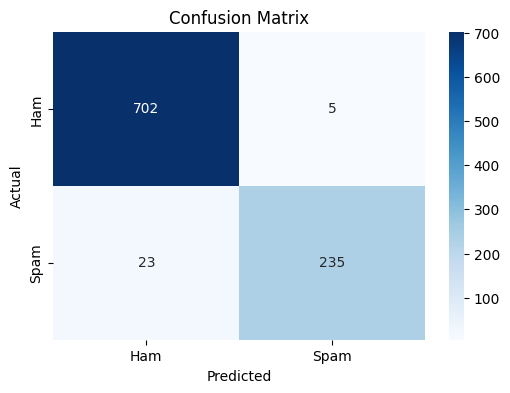

Accuracy: 0.97


In [7]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt="d",
            cmap="Blues",
            xticklabels=["Ham", "Spam"],
            yticklabels=["Ham", "Spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

In [8]:
# Get top 20 spam/ham indicators
feature_names = tfidf.get_feature_names_out()
ham_coefs = nb_model.feature_log_prob_[0]
spam_coefs = nb_model.feature_log_prob_[1]

top_ham_words = [feature_names[i] for i in ham_coefs.argsort()[-20:][::-1]]
top_spam_words = [feature_names[i] for i in spam_coefs.argsort()[-20:][::-1]]

print("Top Ham Indicators:", top_ham_words)
print("Top Spam Indicators:", top_spam_words)

Top Ham Indicators: ['ect', 'enron', 'hpl', 'deal', 'xl', 'hou', 'subject', 'meter', 'gas', 'please', 'nom', 'attach', 'file', 'see', 'daren', 'mmbtu', 'volume', 'thanks', 'pm', 'flow']
Top Spam Indicators: ['subject', 'http', 'com', 'get', 'www', 'price', 'click', 'online', 'email', 'offer', 'want', 'best', 'new', 'free', 'save', 'time', 'low', 'money', 'company', 'order']


In [9]:
#EXPERIMENT WITH ADVANCED MODELS

# a) SVM
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Randomized Search
svm_model = RandomizedSearchCV(SVC(), svm_params, n_iter=10, cv=3, n_jobs=-1)
svm_model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf']})

In [10]:
# b) Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf_model = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=3, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]})

In [11]:
# c) LSTM Deep Learning

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Ensure labels are numeric (0 for ham, 1 for spam)
df["label"] = df["label"].map({"ham": 0, "spam": 1})

# Convert text to sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df["text"])
X_seq = tokenizer.texts_to_sequences(df["text"])
X_pad = pad_sequences(X_seq, maxlen=200)

# Split sequences
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, df["label"], test_size=0.2, random_state=42)

# Convert labels to numpy array (ensures correct dtype)
import numpy as np
y_train_lstm = np.array(y_train_lstm)
y_test_lstm = np.array(y_test_lstm)

# Model architecture
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.7711 - loss: 0.4660
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.9788 - loss: 0.0846
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.9957 - loss: 0.0215
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - accuracy: 0.9981 - loss: 0.0079
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.9996 - loss: 0.0034


In [12]:
# 2) HYPERPARAMETER TUNING
# -> Grid Search for SVM

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for SVM
svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Randomized Search for SVM
svm_random = RandomizedSearchCV(SVC(), svm_params, n_iter=10, cv=3, n_jobs=-1, random_state=42)
svm_random.fit(X_train, y_train)
print("Best SVM Params:", svm_random.best_params_)

Best SVM Params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}


In [13]:
# -> Random Forest Optimization
# Define the parameter grid for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Randomized Search for Random Forest
rf_random = RandomizedSearchCV(RandomForestClassifier(), rf_params, n_iter=10, cv=3, n_jobs=-1, random_state=42)
rf_random.fit(X_train, y_train)
print("Best Random Forest Params:", rf_random.best_params_)
print("Feature Importances:", rf_random.best_estimator_.feature_importances_[:10])


Best Random Forest Params: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}
Feature Importances: [1.05500466e-05 0.00000000e+00 5.94985126e-05 0.00000000e+00
 0.00000000e+00 8.34572543e-05 6.14757864e-05 2.47694778e-05
 2.04638106e-07 0.00000000e+00]


In [14]:
# 3) MODEL COMPARISON

from sklearn.metrics import accuracy_score, precision_score, recall_score

# Model comparison
models = {
    "Naive Bayes": nb_model,
    "SVM": svm_model.best_estimator_,
    "Random Forest": rf_model.best_estimator_
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label="spam"),
        "Recall": recall_score(y_test, y_pred, pos_label="spam")
    })

results_df = pd.DataFrame(results)
print(results_df)


           Model  Accuracy  Precision    Recall
0    Naive Bayes  0.970984   0.979167  0.910853
1            SVM  0.986528   0.972973  0.976744
2  Random Forest  0.976166   0.940075  0.972868


In [17]:
# 4) SCALABLE TRAINING PIPELINE

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Best parameters from RandomizedSearchCV
best_params = {
    'kernel': 'rbf',
    'gamma': 'scale',
    'C': 1
}

# Create pipeline with SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,      # Match EDA settings
        ngram_range=(1, 2),     # Include bigrams
        stop_words='english'     # Reduce noise
    )),
    ('classifier', SVC(**best_params))  # Optimized SVM
])

# Train on full dataset
pipeline.fit(df['text'], df['label'])

# Save pipeline (TF-IDF + SVM)
joblib.dump(pipeline, "spam_detection_pipeline.pkl")

print("SVM pipeline trained and saved!")


SVM pipeline trained and saved!
